# Code Associated with Research Question 1

__Research Question 1__ <br>
"Is there a change in the low-frequency power between _not learned_ and _learned_ conditions?"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import neuropsy as npsy
import neuropsy.analysis as npsya
import pickle
import json
import pandas
import time
from scipy import signal
from scipy.fftpack import next_fast_len

# 0. Deciding Wavelet Parameters and Helper Functions

### Decide Center Frequencies and Number of Cycles for Complex Morelet Wavelet

In [ ]:
# wavelet parameters
fs                          = 512
t_wl                        = np.arange(-4, 4+1/fs, 1/fs) # long enough time to capture the wavelet for given f and n
frequencies                 = np.arange(2, 32, 2)
cycles                      = np.insert(np.flipud(np.arange(3, 13, 1)), [-1, -2, -3, -4, -5], [3, 4, 5, 6, 7])
n_half_wavelet              = len(t_wl) // 2

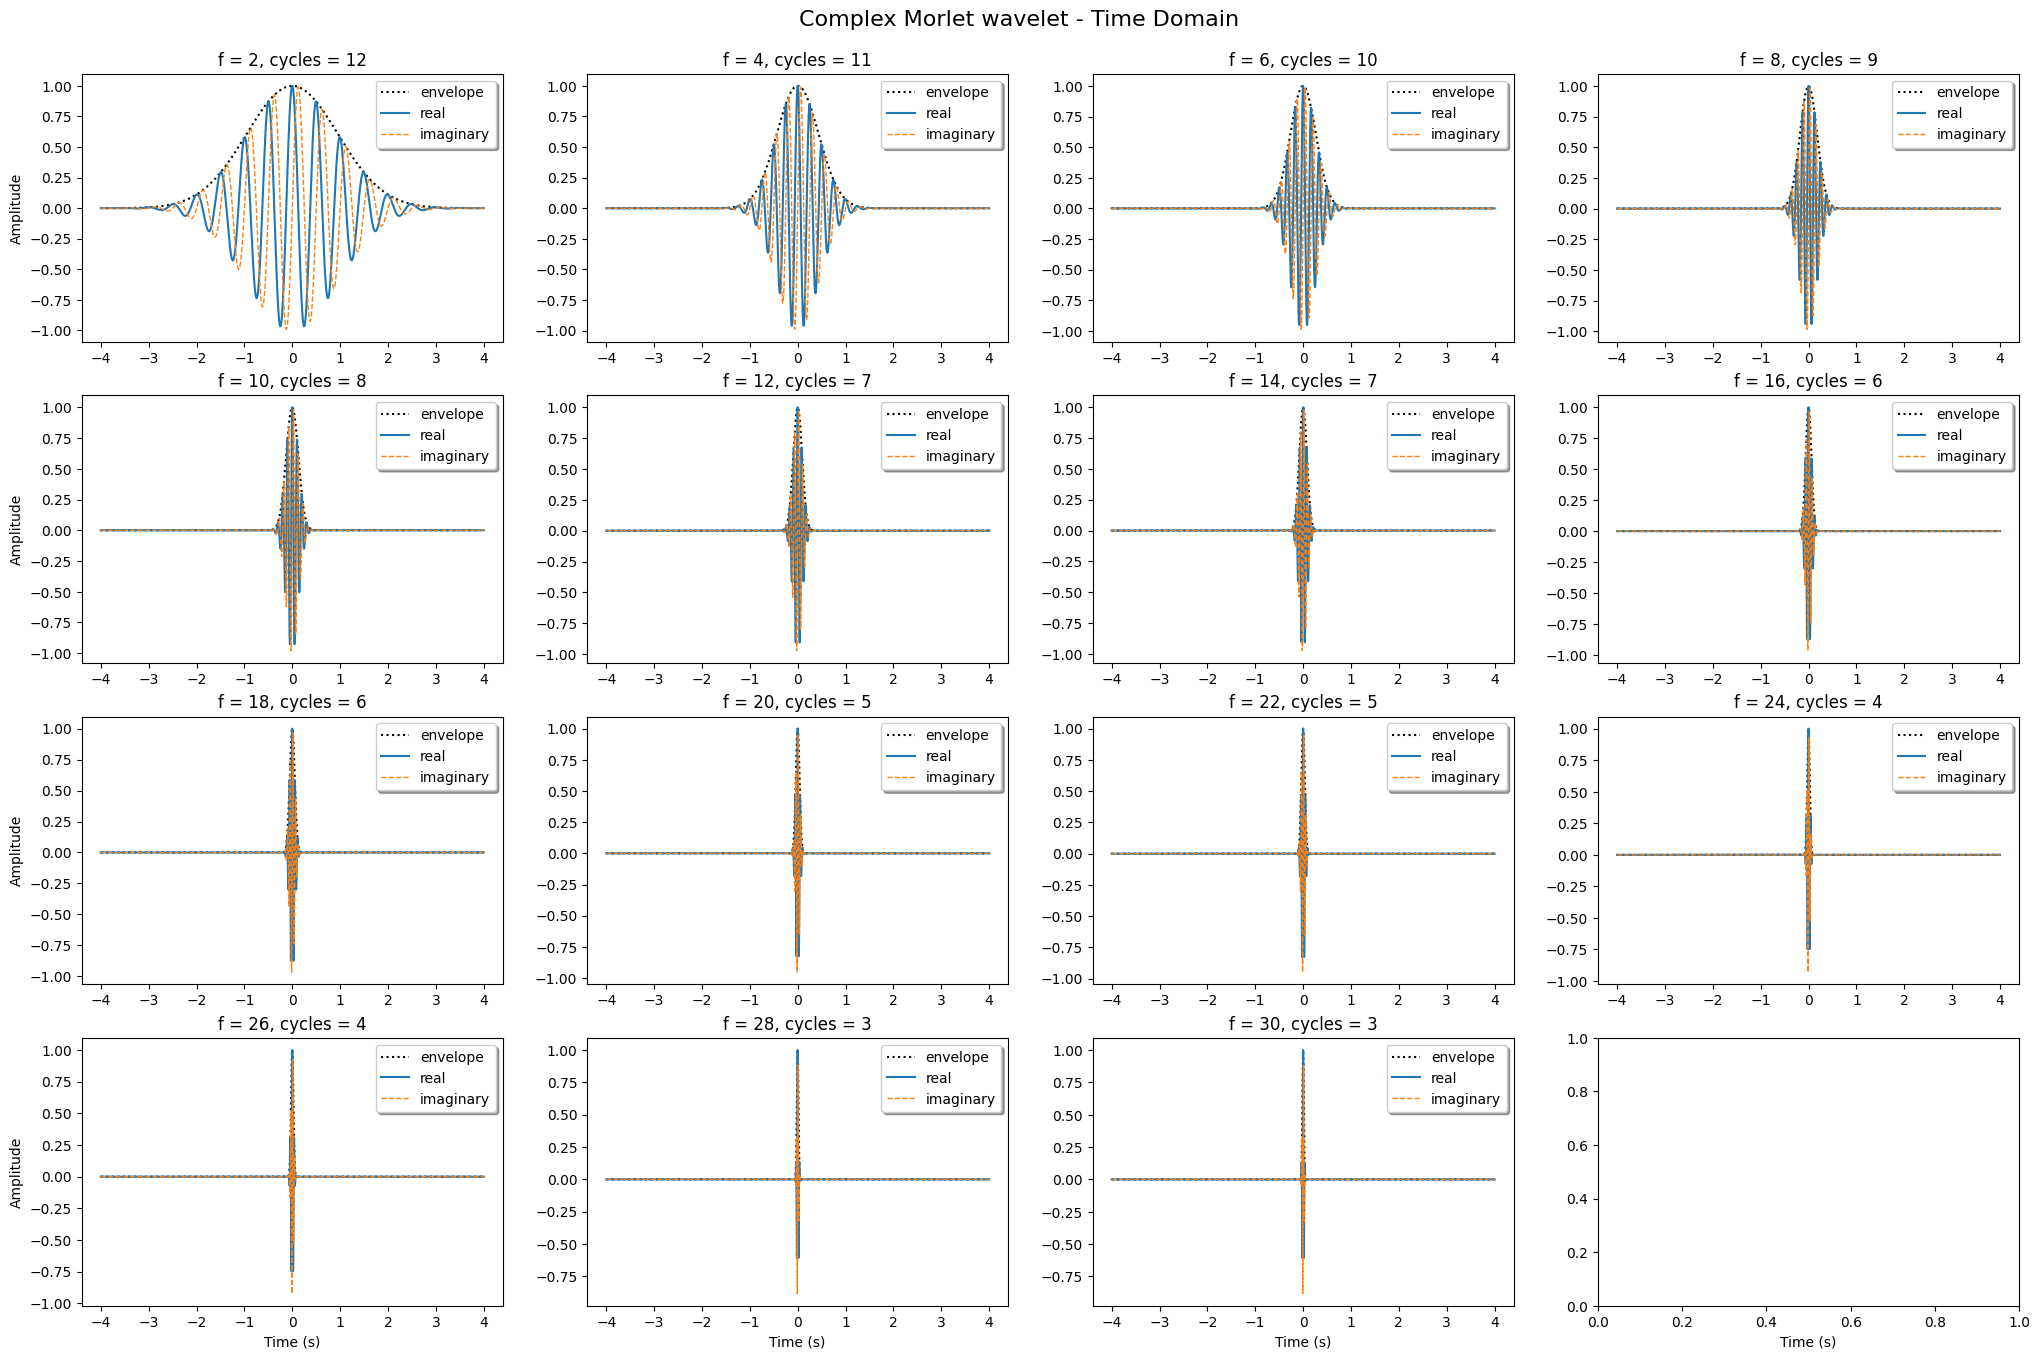

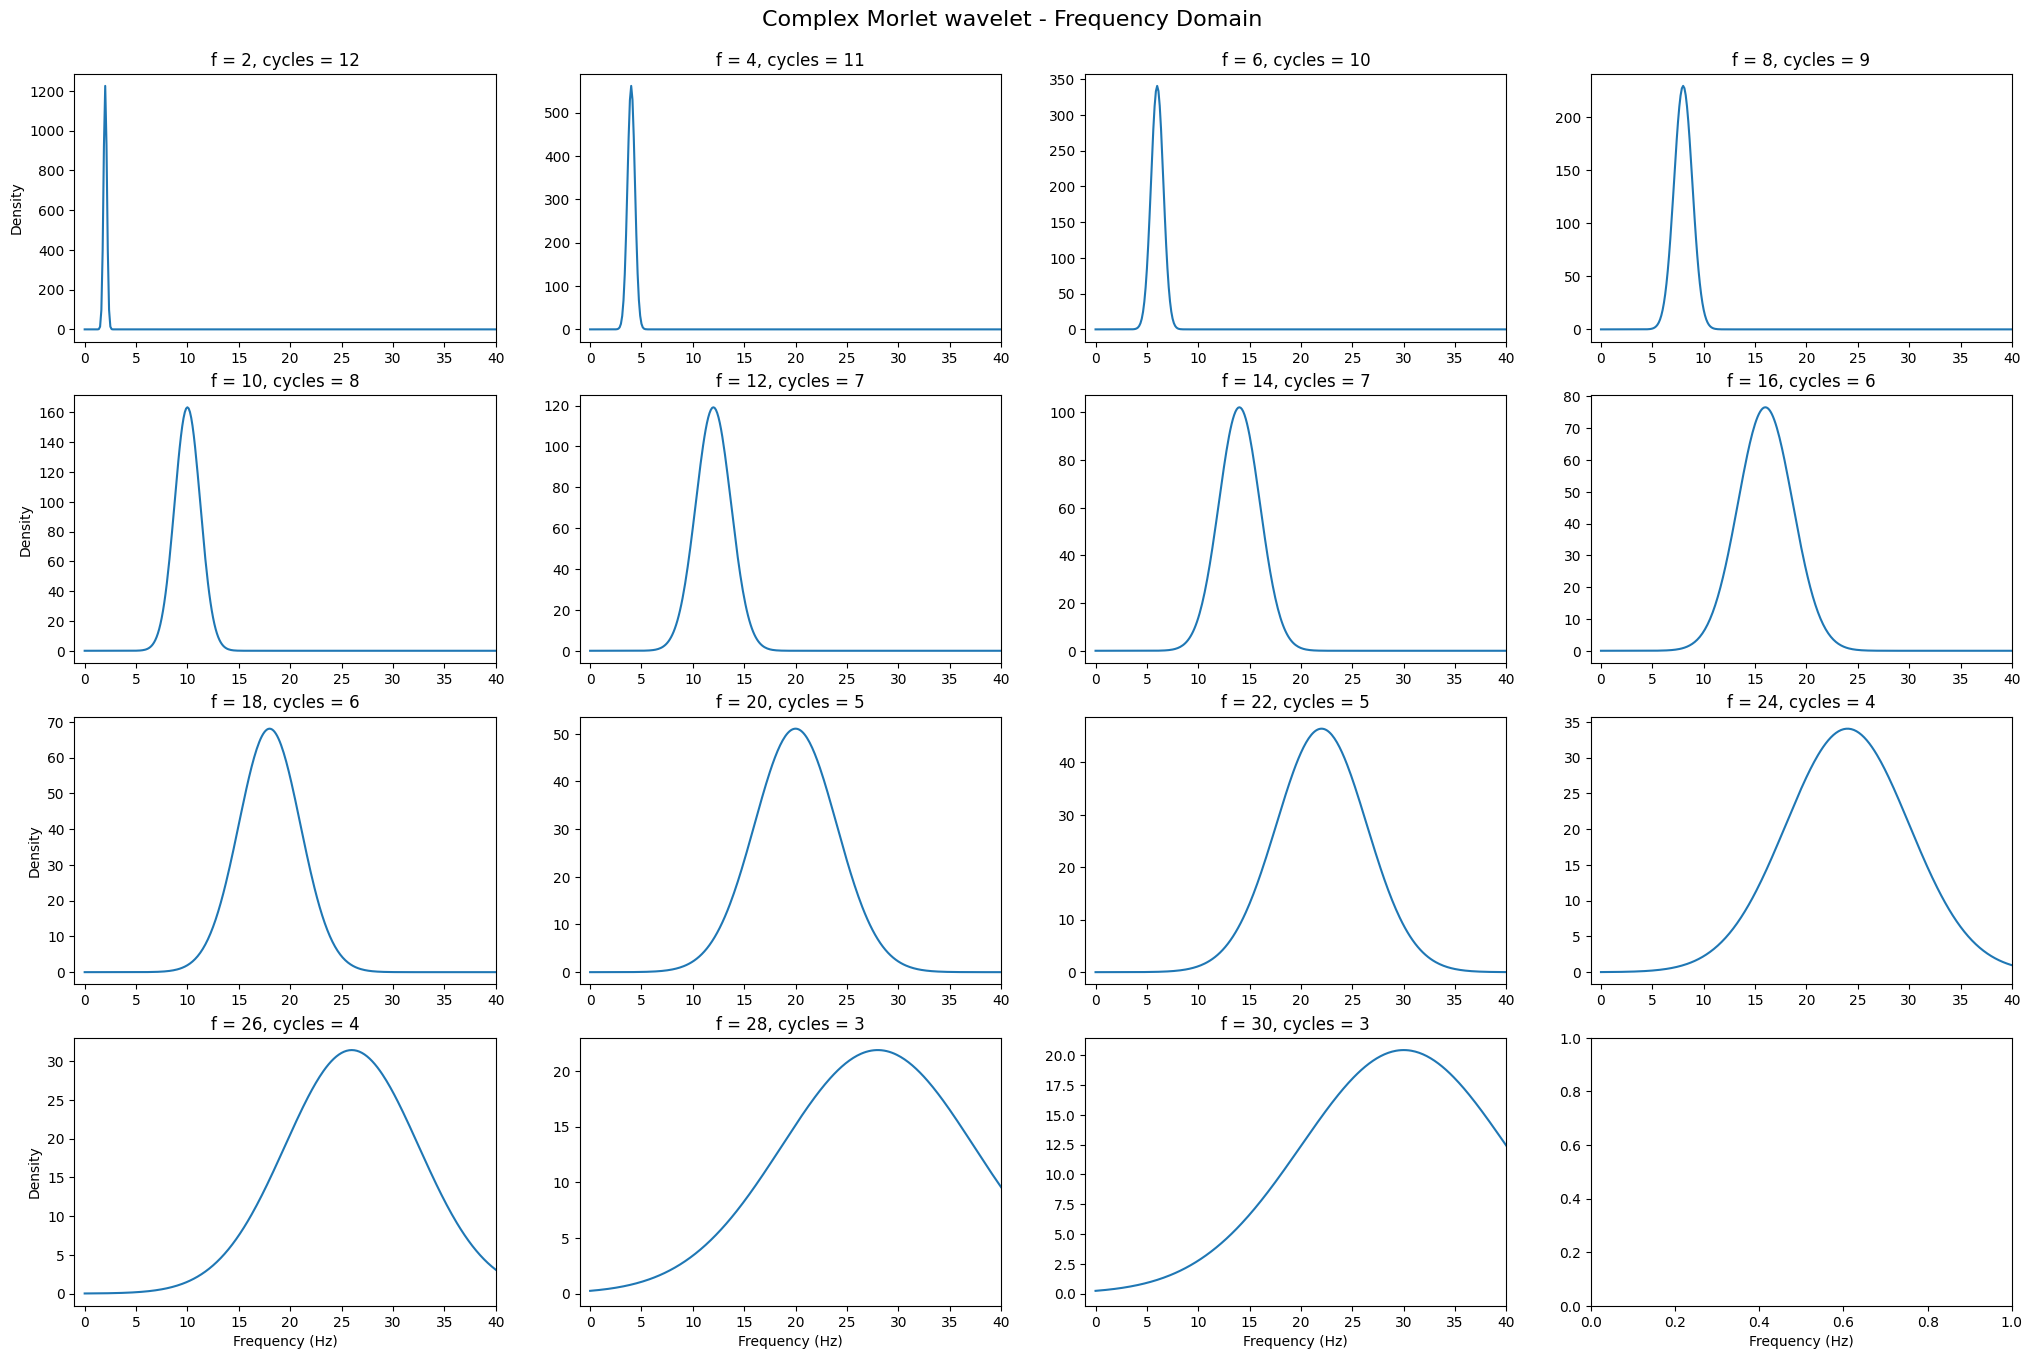

In [3]:
def plot_wavelets(frequencies, cycles, t_wl, fs):
    
    nrows = np.ceil(np.sqrt(len(frequencies))).astype(int)
    
    fig, ax = plt.subplots(figsize=(25, nrows*4), nrows=nrows, ncols=4)#, sharex=True, sharey=True)
    fig2, ax2 = plt.subplots(figsize=(25, nrows*4), nrows=nrows, ncols=4)#, sharex=True, sharey=True)
    ax = ax.flatten()
    ax2 = ax2.flatten()

    wavelet_funcs = {}
    for i, (f, n) in enumerate(zip(frequencies, cycles)):

        # create complex Morlet wavelet
        wavelet, gauss_env = npsya.morlet(f, n, t_wl, return_gaussian=True)
        wavelet_funcs[f] = wavelet
        
        # plot wavelet and gaussian envelope
        ax[i].plot(t_wl, gauss_env, ':', label='envelope', color='black')
        ax[i].plot(t_wl, wavelet.real, label='real')
        ax[i].plot(t_wl, wavelet.imag, label='imaginary', linestyle='--', linewidth=1.)
        ax[i].set_title(f'f = {f}, cycles = {n}')
        if (i % 4 == 0) or (i % 8 == 0) or (i % 12 == 0) or (i % 16 == 0):
            ax[i].set_ylabel('Amplitude')
        if i == 0:
            ax[-1].set_xlabel('Time (s)')
            ax[-2].set_xlabel('Time (s)')
            ax[-3].set_xlabel('Time (s)')
            ax[-4].set_xlabel('Time (s)')
        ax[i].legend(loc='upper right', shadow=True)
        
        # plot frequency spectrum
        xf, y = npsya.compute_fft(wavelet, fs, output='mag')
        ax2[i].plot(xf, y)
        ax2[i].set_title(f'f = {f}, cycles = {n}')
        if (i % 4 == 0) or (i % 8 == 0) or (i % 12 == 0) or (i % 16 == 0):
            ax2[i].set_ylabel('Density')
        if i == 0:
            ax2[-1].set_xlabel('Frequency (Hz)')
            ax2[-2].set_xlabel('Frequency (Hz)')
            ax2[-3].set_xlabel('Frequency (Hz)')
            ax2[-4].set_xlabel('Frequency (Hz)')
        # ax2[i, j].set_yscale('log')
        ax2[i].set_xlim([-1, 40])
        # ax2[i, j].set_ylim([40, 120])
            
    fig.suptitle('Complex Morlet wavelet - Time Domain', fontsize=16, y=.92)
    fig2.suptitle('Complex Morlet wavelet - Frequency Domain', fontsize=16, y=.92)
    plt.show()
    
    
# ********* TEST FUNCTION ********* #
fs                          = 512
t_wl                        = np.arange(-4, 4+1/fs, 1/fs) # long enough time to capture the wavelet for given f and n
frequencies                 = np.arange(2, 32, 2)
cycles                      = np.insert(np.flipud(np.arange(3, 13, 1)), [-1, -2, -3, -4, -5], [3, 4, 5, 6, 7])

plot_wavelets(frequencies, cycles, t_wl, fs)

In [4]:
def average_power_all_channels(power_data, conditions):
    """average_power_all_channels Average power across all channels (also across subjects) for each condition.

    Args:
        power_data (dict): Dictionary with all subjects' power data for each condition and channel.
        conditions (tuple, list): Tuple with conditions to average power across.
        
    Returns:
        power (dict): Dictionary with averaged power data for each condition.
    """
    #********** AVERAGE ALL CHANNELS PER CONDITION **********#
    power = {}
    for condition in conditions:
        print(f"condition: {repr(condition)}")
        power[condition] = []
        for subject_id in power_data.keys():
            for channel in power_data[subject_id][condition].keys():
                # save channel data
                power[condition].append(power_data[subject_id][condition].get(channel))
        print("Shape before average:")
        print(f"\t{np.array(power[condition]).shape}")
        # compute mean of all channels across subjects for condition
        power[condition] = np.mean(power[condition], axis=0)
        print("Shape after average:")
        print(f"\t{np.array(power[condition]).shape}\n")
    return power

def average_power_total(power_data, conditions):
    """average_power_total Average power across all conditions and channels (also across subjects).

    Args:
        power_data (dict): Dictionary with all subjects' power data for each condition and channel.
        conditions (tuple, list): Tuple with conditions to average power across.

    Returns:
        power (np.ndarray): Total averaged power.
    """    
    power = []
    for condition in conditions:
        print(f"condition: {repr(condition)}")
        for subject_id in power_data.keys():
            for channel in power_data[subject_id][condition].keys():
                # save channel data
                power.append(power_data[subject_id][condition].get(channel))
    print("Shape before average:")
    print(f"\t{np.array(power).shape}")
    # compute mean of all channels across subjects
    power = np.mean(power, axis=0)
    print("Shape after average:")
    print(f"\t{np.array(power).shape}\n")
    return power

# 1. Time-frequency Power Analysis 

- Analyse Entire hippocampus
- Manual convolution
- 4 conditions ("not learned", "correct", "learned-1", "learned") 
- Time bins between stimulus onset (picture shown) and stimulus offset (picture placed)
- Baseline correct within trials (-1 s to -0.6 s before stimulus onset)


- NaNs are removed during preprocessing
- outliers are removed here before power analysis

Steps:
1. Iterate over all subjects
2. Compute time-frequency power for each channel in each subject
3. Cut baseline epochs and trial epochs
4. Baseline correct trial epochs
5. 

In [4]:
#********** PARAMETERS **********#
path_data                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
path_save                   = f'/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
subject_ids                 = npsy.utils.get_subject_ids_from_path(path_data)

# analysis parameters
conditions                  = ('not learned', 'correct', 'learned-1', 'learned')
cond_column                 = 'Condition'
stimulus_onset              = 'Picture Shown'
stimulus_offset             = 'Picture Placed'
nbins_between               = 512
save_postfix                = 'picshownandplaced'
tmin                        = -.5                   # time before stimulus onset
tmax                        = 1                     # time after stimulus offset
baseline                    = (-1, -.5)             # time period from before stimulus onset to use for baseline correction
baseline_method             = 'mean'                # basline correction method (see )

# wavelet parameters
fs                          = 512
t_wl                        = np.arange(-4, 4+1/fs, 1/fs) # long enough time to capture the wavelet for given f and n
frequencies                 = np.arange(2, 32, 2)
cycles                      = np.insert(np.flipud(np.arange(3, 13, 1)), [-1, -2, -3, -4, -5], [3, 4, 5, 6, 7])
n_half_wavelet              = len(t_wl) // 2

# plot parameters
cmap                        = 'RdBu_r'

# set up directory for saving results
if not os.path.exists(path_save):
    os.makedirs(path_save)
    os.makedirs(f"{path_save}/data")

### 1.1 Power Analysis

In [ ]:
# save general analysis info (will be saved as json file in the end)
dict_analysis_info = {}
dict_analysis_info['general'] = {}
dict_analysis_info['general']['conditions'] = conditions
dict_analysis_info['general']['cond_column'] = cond_column
dict_analysis_info['general']['stimulus_onset'] = stimulus_onset
dict_analysis_info['general']['stimulus_offset'] = stimulus_offset
dict_analysis_info['general']['nbins_between'] = nbins_between
dict_analysis_info['general']['tmin'] = tmin
dict_analysis_info['general']['tmax'] = tmax
dict_analysis_info['general']['baseline'] = baseline
dict_analysis_info['general']['baseline_method'] = baseline_method


#********** START ANALYSIS **********#
dict_tfr_power_results = {}
for subject_id in subject_ids:
    
    # initialise variables
    dict_tfr_power_results[subject_id]  = {}
    trial_names_outliers                = None
    labels_outliers                     = None
    dict_outliers                       = {}
    trial_names_too_short_or_close      = None
    labels_too_short_or_close           = None
    dict_drop                           = {}
    
    
    start_time_sub = time.time()
    print(f"Starting subject {subject_id}...")

    #********** LOAD SUBJECT DATA **********# 
    data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed')
    
    # subtract total mean from each channel to remove DC bias
    print("Removing DC bias from iEEG data...")
    total_mean = np.mean(data.ieeg)
    for i in range(data.ieeg.shape[0]):
        data.ieeg[i, :] = data.ieeg[i, :] - total_mean
        data.ieeg[i, :] = signal.detrend(data.ieeg[i, :])
        
    # select channels in hippocampus
    print(f"Selecting channels in hippocampus...")
    ch_names = data.df_chan.loc[data.df_chan['DK_Subfields'].str.contains('HP_head|HP_body|HP_tail', case=True)].name.to_list()
    # check that there are channels in the hippocampal subfield for this subject, otherwise skip
    if len(ch_names) > 0:
        data.select_channels(ch_names=np.ravel(ch_names), inplace=True)
        print(f"Selected {len(ch_names)} channels in hippocampus.")
    else:
        print(f"No channels in hippocampus.")
    
    # remove outliers
    print("Removing outliers from experiment dataframe...")
    idx_outliers = data.df_exp[data.df_exp['outlier'] == True]['outlier'].index.to_list()
    if len(idx_outliers) > 0:
        trial_names_outliers    = data.df_exp[data.df_exp['outlier'] == True]['Trial Identifier'].to_list()
        labels_outliers         = data.df_exp.loc[idx_outliers, cond_column].to_list()
        for i, label in zip(idx_outliers, labels_outliers):
            if label not in dict_outliers.keys():
                dict_outliers[label] = 1
            else:
                dict_outliers[label] += 1
        for key, value in dict_outliers.items():
            print(f"{value} outliers in condition {repr(key)}.")
        data.df_exp = data.df_exp.drop(idx_outliers).reset_index(drop=True)
    else:
        print("No outliers in experiment dataframe.")

    # [INFO] need to make sure trials have enough time points for the chosen nbins_between
    #********** CHECK TRIAL DURATIONS **********# 
    print("Checking trial durations...")
    print(f"\tmax duration between onset and offset is {round(nbins_between / fs, 2)} seconds.")
    idx_too_short, idx_too_close = npsya.check_trials(df=data.df_exp, col_name=cond_column, tmin=tmin, tmax=round(nbins_between / fs, 2), baseline=baseline)
    idx_drop = np.unique(np.concatenate((idx_too_short, idx_too_close))).astype(int).tolist()
    if len(idx_drop) > 0:
        trial_names_too_short_or_close  = data.df_exp.loc[idx_drop, 'Trial Identifier'].to_list()
        labels_too_short_or_close       = data.df_exp.loc[idx_drop, cond_column].to_list()
        for i, label in zip(idx_drop, labels_too_short_or_close):
            if label not in dict_drop.keys():
                dict_drop[label] = 1
            else:
                dict_drop[label] += 1
        for key, value in dict_drop.items():
            print(f"{value} are too short or too close with other trials in condition {repr(key)}.")
        data.df_exp = data.df_exp.drop(idx_drop).reset_index(drop=True)
    else:
        print("No trials are too short or too close with other trials.")

    #********** CREATE MNE RAW OBJECT WITH iEEG DATA **********#
    data.create_raw()
    

    #********** GET TRIAL TIME POINTS (INDICES) **********#
    # need trial indices for conditions from experiment dataframe
    # also need the corresponding trial indices for the baseline (picture shown)
    dict_trial_indices = {**{f'{c}_onset': [] for c in conditions}, **{f'{c}_offset': [] for c in conditions}, **{f'{c}_baseline': [] for c in conditions}}
    for c in conditions:
        # get the trial indices for the condition
        idx_onset       = data.df_exp[data.df_exp[cond_column] == c][f'Mark for {stimulus_onset}'].to_numpy().astype(int).tolist()
        idx_offset      = data.df_exp[data.df_exp[cond_column] == c][f'Mark for {stimulus_offset}'].to_numpy().astype(int).tolist()
        idx_baseline    = data.df_exp[data.df_exp[cond_column] == c]['Mark for Picture Shown'].to_numpy().astype(int).tolist()
        # save indices
        dict_trial_indices[f"{c}_onset"].append(idx_onset)
        dict_trial_indices[f"{c}_offset"].append(idx_offset)
        dict_trial_indices[f"{c}_baseline"].append(idx_baseline)
    # flatten
    for key in dict_trial_indices.keys():
        dict_trial_indices[key] = np.ravel(dict_trial_indices[key])


    #********** TIME-FREQUENCY ANALYSIS **********#
    if len(ch_names) > 0:
    
        # condition perhaps vary in trial number
        for condition in conditions:
            start_time_cond = time.time()
            print(f"\tStarting condition {repr(condition)}...")
            
            dict_tfr_power_results[subject_id][condition] = {}
            
            for ch in ch_names:
                start_time_ch = time.time()
                
                # use the whole channel signal for computing time-frequency representation
                ch_signal = data.raw._data[ch_names.index(ch), ...]
                
                # ********* FFT of CHANNEL ********* #
                n_conv      = len(t_wl) + len(ch_signal) - 1
                n_conv_fast = next_fast_len(n_conv)
                signal_fft  = np.fft.fft(ch_signal, n_conv_fast)
                
                
                # initialise output data for continuous wavelet transform
                tf_data = np.zeros((len(frequencies), len(ch_signal)))

                # ********* CWT ********* #
                for i, (f, n) in enumerate(zip(frequencies, cycles)):
                    
                    # [INFO] - print current wavelet parameters
                    # print(f"creating wavelet with parameters: f = {f}, n = {n}...")
                    
                    # create wavelet
                    wavelet = npsya.morlet(f, n, t_wl)
                    
                    # fft of wavelet
                    # note:
                    #   output must match the length of the signal_fft in order to multiply in the frequency domain
                    wavelet_fft = np.fft.fft(wavelet, n=n_conv_fast)
                    
                    # convolution
                    coefficients = np.fft.ifft(signal_fft * wavelet_fft, n=n_conv_fast)
                    coefficients = coefficients[:n_conv] # remove padding from next_fast_len
                    coefficients = coefficients[n_half_wavelet:-n_half_wavelet]
                    
                    # convert to power in dB
                    tf_power = 10 * np.log10(np.abs(coefficients)**2)
                    
                    # store result for frequency
                    tf_data[i, :] = tf_power
                
                # ********* POSTPROCESSING ********* #
                # Note:
                #   - baseline correction is done for each trial separately
                #   - tmin before onset, bins between onset and offset, tmax after offset
                #   - average power across trials leaving channel averages per subject
                all_trials_corrected = []
                for i in range(len(dict_trial_indices[f'{condition}_onset'])):
                    # get onset, offset, and basline indices for trial
                    i_onset = dict_trial_indices[f'{condition}_onset'][i]
                    i_offset = dict_trial_indices[f'{condition}_offset'][i]
                    i_baseline = dict_trial_indices[f'{condition}_baseline'][i]
                    # get power for trial period
                    i_tmin = int(i_onset + int(tmin * fs))
                    i_tmax = int(i_offset + int(tmax * fs))
                    power_trial = tf_data[:, i_tmin:i_tmax]
                    # get power for baseline period
                    b_tmin = int(i_baseline + int(baseline[0] * fs))
                    b_tmax = int(i_baseline + int(baseline[1] * fs))
                    power_baseline = tf_data[:, b_tmin:b_tmax]
                    # baseline correction
                    tf_data[:, i_tmin:i_tmax] = npsya.apply_baseline(epoch_power=power_trial, baseline_power=power_baseline, method=baseline_method)
                    
                    # create bins between onset and offset
                    power_bins = np.array_split(tf_data[:, i_onset:i_offset], nbins_between, axis=1)
                    # average bins across time (this will be the new time points, only this time in bins)
                    power_bins_avg = np.zeros((len(frequencies), nbins_between))
                    for i, power_bin in enumerate(power_bins):
                        power_bins_avg[:, i] = np.mean(power_bin, axis=1)
                        
                    # store result for trial
                    all_trials_corrected.append(np.concatenate([tf_data[:, i_tmin:i_onset], power_bins_avg, tf_data[:, i_offset:i_tmax]], axis=1))
                    
                # store result for channel - average across trials
                dict_tfr_power_results[subject_id][condition][ch] = np.mean(all_trials_corrected, axis=0)
                
                # clean up
                # del signal, coefficients, baseline_power, baseline_power_avg, power_trials, power_trials_corrected
                print(f"\t\tChannel {ch} done - {time.time() - start_time_ch:.2f} seconds")
            print(f"\tCondition {repr(condition)} done - {time.time() - start_time_cond:.2f} seconds")
        print(f"Subject {subject_id} done - {time.time() - start_time_sub:.2f} seconds")
    else:
        # remove subject from results if there are no channels in the hippocampus
        dict_tfr_power_results.pop(subject_id)
    
    #********** PLOT RESULTS **********#
    # only plot if there are channels in the hippocampus
    if len(ch_names) > 0:
        for ch in ch_names:
            fig, ax = plt.subplots(ncols=len(conditions), nrows=1, figsize=(15, 3), layout='compressed')
            for i, condition in enumerate(conditions):
                im = ax[i].imshow(
                    dict_tfr_power_results[subject_id][condition][ch], 
                    aspect='auto',
                    extent=[0, 1279, (frequencies)[0], (frequencies)[-1]],
                    origin='lower', 
                    vmin=-3,
                    vmax=3,
                    cmap=cmap,
                    interpolation='hanning')
                ax[i].set_title(f'{condition} - {ch}', fontsize=12)
                ax[0].set_ylabel('Frequency (Hz)', fontsize=11)                  # only set ylabel for left most plots
                # ax[i].set_xlabel('Trial Period', fontsize=11)
                
                # show frequency in log scale
                ax[i].set_yscale('log')                              
                ax[i].set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
                
                # add line at onset and offset
                ax[i].axvline(x=255, color='black', linestyle='--', linewidth=1.)
                ax[i].axvline(x=255+512, color='black', linestyle='--', linewidth=1.)
                
                # set custom x ticks to account for bins and time points being plotted together
                xticks  = [0, 127, 255, 355, 455, 555, 655, 767, 1023, 1279]
                xlabels = ["-0.5 s", "-0.25 s", 'onset', 'b100', 'b200', 'b300', 'b400', 'offset', "0.5 s", "1 s"]
                ax[i].set_xticks(xticks, xlabels, rotation=45, fontsize=10)
                
            # add colorbar for the entire figure
            cbar = plt.colorbar(im, ax=ax.ravel().tolist(), shrink=0.70, pad=0.01, orientation="vertical")
            cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=11)
            fig.suptitle(f"Subject {data._subject_id} - Hippocampus", fontsize=14, y=1.06, x=.49)
            
            print(f"Saving plot for subject {data._subject_id}...")
            full_save_path = f"{path_save}/1.1 sub{data._subject_id}_{ch}_power.png"
            fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
            print(f"Done - {full_save_path}")
            plt.close(fig)
                
        # [REMOVE] - use instead above method to plot all channels separately
        # fig, ax = plt.subplots(nrows=len(conditions), ncols=len(ch_names), figsize=(10*len(ch_names), 4*len(conditions)), layout='compressed')
        # # add extra dimension if only one channel to avoid error
        # if len(ch_names) == 1:
        #     ax = np.expand_dims(ax, axis=1)
        # for i, condition in enumerate(conditions):
        #     for j, ch in enumerate(ch_names):
                
        #         im = ax[i, j].imshow(
        #             dict_tfr_power_results[subject_id][condition][ch], 
        #             aspect='auto',
        #             extent=[0, 1279, (frequencies)[0], (frequencies)[-1]],
        #             origin='lower', 
        #             vmin=-3,
        #             vmax=3,
        #             cmap=cmap,
        #             interpolation='hanning')
                
        #         ax[i, j].set_title(f'{condition} - {ch}', fontsize=16)
        #         ax[i, 0].set_ylabel('Frequency (Hz)', fontsize=12)                  # only set ylabel for left most plots
        #         ax[len(conditions)-1, j].set_xlabel('Trial Period', fontsize=12)    # only set xlabel for bottom plots
                
        #         # show frequency in log scale
        #         ax[i, j].set_yscale('log')                              
        #         ax[i, j].set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
                
        #         # add line at onset and offset
        #         ax[i, j].axvline(x=255, color='black', linestyle='--', linewidth=1.)
        #         ax[i, j].axvline(x=255+512, color='black', linestyle='--', linewidth=1.)
                
        #         # set custom x ticks to account for bins and time points being plotted together
        #         xticks  = [0, 127, 255, 355, 455, 555, 655, 767, 1023, 1279]
        #         xlabels = [-.5, -.25, 'onset', 'b100', 'b200', 'b300', 'b400', 'offset', .5, 1]
        #         ax[i, j].set_xticks(xticks, xlabels, rotation=45)
                
        # # add colorbar for the entire figure
        # cbar = plt.colorbar(im, ax=ax.ravel().tolist(), shrink=0.70, pad=0.01, orientation="vertical")
        # cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)
        # fig.suptitle(f"Subject {data._subject_id} - Hippocampus", fontsize=18, y=1.03, x=.49)

        # print(f"Saving plot for subject {data._subject_id}...")
        # full_save_path = f"{path_save}/1.1 sub{data._subject_id}_power_chan.png"
        # fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
        # print(f"Done - {full_save_path}")
        # plt.close(fig)
        # plt.show()
    
    # save analysis info for subject
    tmp_dict_conditions         = {f'{c}': len(dict_trial_indices[f'{c}_onset']) for c in conditions}
    tmp_dict_outliers           = {**{f'{c}': dict_outliers.get(c, 0) for c in conditions}, **{'count': len(idx_outliers)}, **{'indices': idx_outliers}, **{'trial_identifiers': trial_names_outliers}}
    tmp_dict_too_short_or_close = {**{f'{c}': dict_drop.get(c, 0) for c in conditions}, **{'count': len(idx_drop)}, **{'indices': idx_drop}, **{'trial_identifiers': trial_names_too_short_or_close}}
    
    dict_analysis_info[f'subject {subject_id}'] = {
        'trials_kept': tmp_dict_conditions if len(ch_names) > 0 else None,
        'trials_dropped': {
            'outliers': tmp_dict_outliers,
            'too_short_or_too_close': tmp_dict_too_short_or_close
        } if len(ch_names) > 0 else None,
        'channels': ch_names if len(ch_names) > 0 else None
    }
    
    # break
        

#********** SAVE RESULTS **********#
filename = f"{path_save}/data/tfr_power_results.pkl"
with open(filename, 'wb') as f:
    print(f"Saving results as {repr(filename)}...")
    pickle.dump(dict_tfr_power_results, f)
    print("Done")
#********** SAVE ANALYSIS INFO **********#
filename = f"{path_save}/data/tfr_analysis_info.json"
with open(filename, 'w') as f:
    print(f"Saving analysis info as {repr(filename)}...")
    json.dump(dict_analysis_info, f)
    print("Done")

Starting subject 03...
Removing DC bias from iEEG data...
Selecting channels in hippocampus...
Selected 5 channels in hippocampus.
Removing outliers from experiment dataframe...
4 outliers in condition 'not learned'.
1 outliers in condition 'learned-1'.
Checking trial durations...
	max duration between onset and offset is 1.0 seconds.
Checking if any trials are too short for tmax = 1.0 ...
1 trials in condition 'learned-1' too short.
1 trials in condition 'learned' too short.
Checking if any trials are too close to each other for tmin = -0.5 s and baseline tmin = -1.0 s ...
All trials are far enough apart.
1 are too short or too close with other trials in condition 'learned-1'.
1 are too short or too close with other trials in condition 'learned'.
Creating RawArray with float64 data, n_channels=5, n_times=823114
    Range : 0 ... 823113 =      0.000 ...  1607.643 secs
Ready.
	Starting condition 'not learned'...
		Channel B' 02 done - 0.90 seconds
		Channel B' 03 done - 0.96 seconds
		C

### 1.2 Average Within Conditions

In [18]:
filename = f"{path_save}/data/tfr_power_results.pkl"

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    power_data = pickle.load(f)
    
    
#********** AVERAGE ALL CHANNELS PER CONDITION **********#
power_averaged = npsya.get_conditions_avg_power(power_data, conditions)

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(ncols=len(conditions), nrows=1, figsize=(15, 3), layout='compressed')
for i, condition in enumerate(conditions):
        
    im = ax[i].imshow(
        power_averaged[condition], 
        aspect='auto',
        extent=[0, 1279, (frequencies)[0], (frequencies)[-1]],
        origin='lower', 
        vmin=-1,
        vmax=1,
        cmap=cmap,
        interpolation='hanning')
    
    ax[i].set_title(f'{condition}', fontsize=12)
    ax[0].set_ylabel('Frequency (Hz)', fontsize=11)        # only set ylabel for left most plots
    # ax[i].set_xlabel('Trial Period', fontsize=11)
    
    # show frequency in log scale
    ax[i].set_yscale('log')                              
    ax[i].set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
    
    # add line at onset and offset
    ax[i].axvline(x=255, color='black', linestyle='--', linewidth=1.)
    ax[i].axvline(x=255+512, color='black', linestyle='--', linewidth=1.)
    
    # set custom x ticks to account for bins and time points being plotted together
    xticks  = [0, 127, 255, 355, 455, 555, 655, 767, 1023, 1279]
    xlabels = ["-0.5 s", "-0.25 s", 'onset', 'b100', 'b200', 'b300', 'b400', 'offset', "0.5 s", "1 s"]
    ax[i].set_xticks(xticks, xlabels, rotation=45, fontsize=10)
    
    # add colorbar for the entire figure
    # cbar = plt.colorbar(im, ax=ax[i], shrink=0.70, pad=0.01, orientation="vertical")
    # cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)
        
# add colorbar for the entire figure
cbar = plt.colorbar(im, ax=ax.ravel().tolist(), shrink=0.70, pad=0.01, orientation="vertical")
cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=11)
fig.suptitle('Hippocampus Average', fontsize=14, y=1.06, x=.49)

full_save_path = f"{path_save}/1.2 average_conditions.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.close()

### 1.3 Average Total

In [17]:
filename = f"{path_save}/data/tfr_power_results.pkl"

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    power_data = pickle.load(f)
    
    
#********** AVERAGE ALL CHANNELS PER CONDITION **********#
power_total_avg = npsya.get_total_avg_power(power_data, conditions)

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), layout='compressed')
        
im = ax.imshow(
    power_total_avg, 
    aspect='auto',
    extent=[0, 1279, (frequencies)[0], (frequencies)[-1]],
    origin='lower', 
    vmin=-1,
    vmax=1,
    cmap=cmap,
    interpolation='hanning')

ax.set_title(f'Hippocampus Total Average', fontsize=12)
ax.set_ylabel('Frequency (Hz)', fontsize=11)        # only set ylabel for left most plots
# ax.set_xlabel('Trial Period', fontsize=12)

# show frequency in log scale
ax.set_yscale('log')                              
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])

# add line at onset and offset
ax.axvline(x=255, color='black', linestyle='--', linewidth=1.)
ax.axvline(x=255+512, color='black', linestyle='--', linewidth=1.)

# set custom x ticks to account for bins and time points being plotted together
xticks  = [0, 127, 255, 355, 455, 555, 655, 767, 1023, 1279]
xlabels = ["-0.5 s", "-0.25 s", 'onset', 'b100', 'b200', 'b300', 'b400', 'offset', "0.5 s", "1 s"]
ax.set_xticks(xticks, xlabels, rotation=45, fontsize=10)
        
# add colorbar for the entire figure
cbar = plt.colorbar(im, ax=ax, shrink=0.70, pad=0.01, orientation="vertical")
cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=11)

full_save_path = f"{path_save}/1.3 average_total.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.close()

condition: 'not learned'
condition: 'correct'
condition: 'learned-1'
condition: 'learned'
Shape before average:
	(256, 15, 1280)
Shape after average:
	(15, 1280)

